## MGSC 695 - Optimization Methods for Data Science

## Winter 2024

## Dr. Sanjith Gopalakrishnan

### Submitted by - Jared Balakrishnan (McGill ID # 261175926)

In [21]:
from pathlib import Path 
import pandas as pd
import numpy as np
import gurobipy as gb 
from gurobipy import *

import matplotlib.pyplot as plt 
import seaborn as sns

In [22]:
dataset_path = Path().absolute() / "dataset"

In [23]:
# function to read in a dataset
def read_df(input_filepath: Path) -> pd.DataFrame:

    return pd.read_csv(input_filepath)

In [24]:
old_faithful = read_df(dataset_path / "faithful.csv")

In [33]:
del old_faithful['Unnamed: 0']

In [34]:
old_faithful.head(3)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74


In [30]:
# Number of instances and features

n = old_faithful.shape[0]
d = old_faithful.shape[1] - 1

print(f"Number of instances: {n}")
print(f"Number of features of interest: {d}")

Number of instances: 272
Number of features of interest: 2


## Problem 1

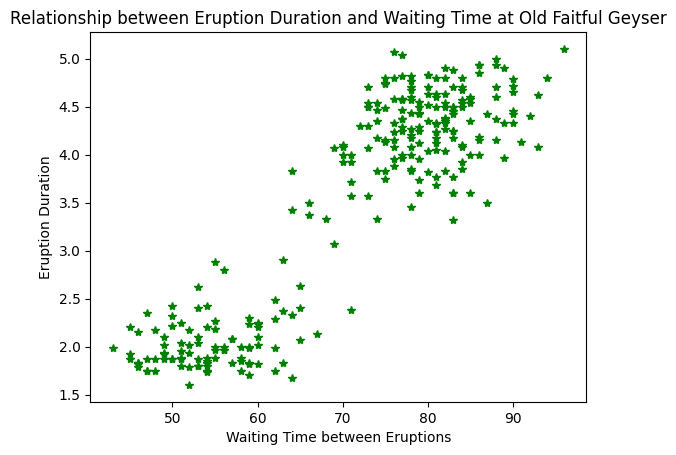

In [20]:
# Visualizing the observations using a scatter plot

plt.plot(old_faithful['waiting'], old_faithful['eruptions'], 'g*')
plt.title('Relationship between Eruption Duration and Waiting Time at Old Faitful Geyser')
plt.xlabel('Waiting Time between Eruptions')
plt.ylabel('Eruption Duration')
plt.show()

## The K-Means Clustering Problem

The K-Means Clustering algorithm is an unsupervised learning method that partitions a given dataset into K distinct, non-overlapping clusters.

In order to perform K-Means clustering algorithms, we need to decide upon the number of clusters (K). The K-Means algorithm then assigns each observation to exactly one of these K clusters.

Let $C_{1}, C_{2}, \cdots, C_{K}$ denote the sets that contain indices of the observations in each cluster:
- $C_{1} \cup C_{2} \cup \cdots \cup C_{K} = \{1, 2, \cdots, n\}$ (This means that each observation belongs to one of the K clusters)
- $ C_k \cap C_{{k'}} = \phi  \forall k \neq k'$ (An observation can only belong to one single cluster)

### The Optimization Problem

When it comes to expressing the K-Means clustering problem as an optimization problem, the principal idea is to minimize the **within-cluster** variation. The within-cluster variation for a given cluster is expressed as the amount by which observations within that particular cluster differ from each other.

Mathematically, the within-cluster variation can be expressed with the help of the Euclidean distance. That is, the within-cluster variation for a given cluster is defined as the sum of all pairwise euclidean distances between the observations in that given cluster divided by the number of observations in said cluster.

That is, with the within-cluster variation for a cluster $k$ being expressed as $W(C_{k})$ :

$$
W(C_k) = \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2
$$

Therefore, the optimization problem can now be summarized as:

$$
\text{minimize} \left\{ \sum_{k=1}^{K} \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 \right\}
$$


In [36]:
# Implementing the K-Means Algorithm from Scratch for Clustering

old_faithful.head(2)

,eruptions,waiting
0,3.6,79
1,1.8,54


In [41]:
# Using Gurobi to find what value of k = {2, 3, 4, 5} yields the least value for the within-cluster variance

K_values = [2, 3, 4, 5]

In [37]:
data = old_faithful.to_numpy()

In [45]:
def find_within_cluster_variance(K):

    model = gb.Model(f"K-Means Clustering when K = {K}")

    z = model.addVars(len(data), K, vtype = GRB.BINARY, name = "z")

    c = model.addVars(K, len(data[0]), vtype = GRB.CONTINUOUS, name = "c")

    # setting up the formula for the within-cluster variance
    exp = gb.quicksum(z[i,k]*gb.quicksum((data[i,j] - c[k,j])*(data[i,j] - c[k,j]) for j in range(len(data[0]))) for i in range(len(data)) for k in range(K))

    # set objective function

    model.setObjective(exp, GRB.MINIMIZE)

    # adding constraints

    constr_exp = (gb.quicksum(z[i,k] for k in range(K)) == 1 for i in range(len(data)))


    model.addConstrs(constr_exp, "Max 1 Cluster per data point")

    model.optimize()

    print(f"The within-cluster variance when K = {K} is: {model.objVal}")







In [47]:
X = old_faithful[['eruptions', 'waiting']].values

In [54]:
def k_means_gurobi(X, K):

    
    n, d = X.shape  # Number of points and dimension of space

    m = gb.Model("k_means")

    # Add variables
    assign = m.addVars(n, K, vtype = GRB.BINARY, name='assign')
    centroids = m.addVars(K, d, vtype = GRB.CONTINUOUS, name='centroids')

    # Add the objective function
    # Notice we are using quicksum and addTerms to handle the quadratic expression

    obj = gb.QuadExpr()
    for i in range(n):
        for k in range(K):
            for j in range(d):
                obj += assign[i, k] * (X[i, j] - centroids[k, j]) * (X[i, j] - centroids[k, j])

    m.setObjective(obj, GRB.MINIMIZE)

    # Add constraints: each point must be in exactly one cluster
    m.addConstrs((assign.sum(i, '*') == 1 for i in range(n)), name='one_cluster')

    
    m.setObjective(obj, GRB.MINIMIZE)

    # Add constraints: each point must be in exactly one cluster
    m.addConstrs((gb.quicksum(assign[i,k] for k in range(K)) == 1 for i in range(n)), name='one_cluster')

    # Optimize the model
    m.optimize()

    print(m.objVal)

In [55]:
for k in K_values:

    k_means_gurobi(X, k)

GurobiError: Invalid argument to QuadExpr multiplication

In [56]:
# Implementing the K-Means Clustering Model


import random 
import math 

In [57]:
class K_Means:

    def __init__(self, k = 3, max_iterations = 500):

        self.k = k 
        self.max_iterations = max_iterations 
    

    def euclidean_distance(self, point_1, point_2):

        return np.linalg.norm(point_1 - point_2, axis = 0)
    
    def fit(self, input_dataset):

        self.centroids = {}

        for i in range(self.k):

            self.centroids[i] = input_dataset[i]
        

        for i in range(self.max_iterations):

            self.classes = {}

            for j in range(self.k):

                self.classes[j] = []
            

            for point in input_dataset:

                distances = []

                for index in self.centroids:

                    distances.append(self.euclidean_distance(point, self.centroids[index]))
                
                cluster_index = distances.index(min(distances))

                self.classes[cluster_index].append(point)

            for cluster_index in self.classes:

                self.centroids[cluster_index] = np.average(self.classes[cluster_index], axis = 0)



In [62]:
# Using the scikit-learn blackbox K-Means 

kms = K_Means(2)

In [63]:
kms.fit(X)

In [64]:
print(kms.centroids)

{0: array([ 4.29793023, 80.28488372]), 1: array([ 2.09433, 54.75   ])}


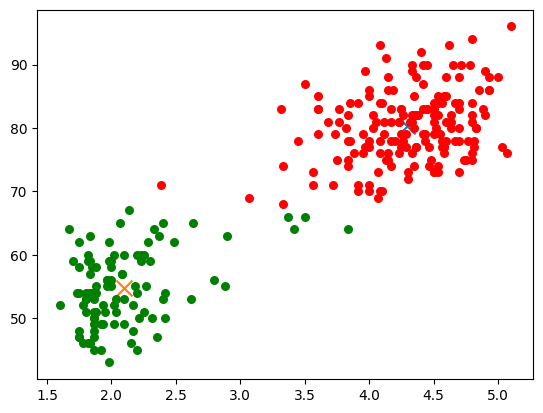

In [65]:
# Plotting starts here
colors = 10*["r", "g", "c", "b", "k"]

for centroid in kms.centroids:
    plt.scatter(kms.centroids[centroid][0], kms.centroids[centroid][1], s = 130, marker = "x")

for cluster_index in kms.classes:
    color = colors[cluster_index]
    for features in kms.classes[cluster_index]:
        plt.scatter(features[0], features[1], color = color,s = 30)

In [66]:
# Testing Image Compression

from sklearn.datasets import load_sample_image    # Datasets containing sample images in the scikit-learn library


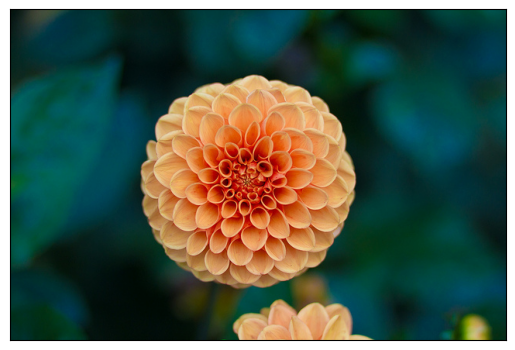

In [67]:
flower = load_sample_image("flower.jpg")            # Loads a sample image flower.jpg
ax = plt.axes(xticks=[], yticks=[])               # Plot the image
ax.imshow(flower);

In [68]:
data = flower / 255.0                # Converts RGB intensity to a [0,1] scale
data = data.reshape(427 * 640, 3)   # Reshapes the image
data.shape

(273280, 3)

In [69]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # Choose a random subset of pixels 

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    # Define the axes and markets on the figure
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

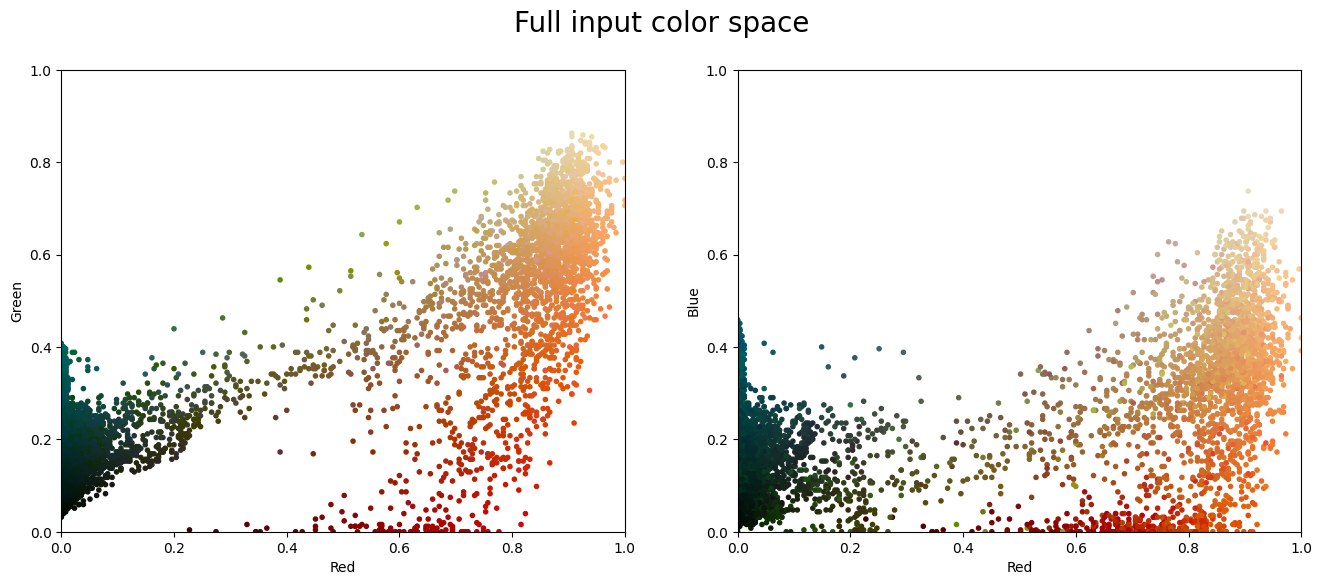

In [70]:
plot_pixels(data, title='Full input color space')


In [ ]:


flower_kmeans = K_Means(16)

flower_kmeans.fit(data)

new_colors = flower_kmeans.centroids

In [ ]:
flower_recolored = new_colors.reshape(flower.shape) # Defines the recolored image

# Plots the original image and the recolored image for comparison

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16);